In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

import warnings
from astropy.units import UnitsWarning

# Data

In [2]:
file_path = 'C:\\Users\\serat\\Downloads\\AGN\\output\\calcos\\epoch1\\lf0a01b0q_1_x1d.fits'


with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w, f, ferr, dq = Table.read(
            file_path)[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']
        
dq_mask = np.where(dq == 0) # filter to good quality data
w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]


t = Table([w, f, ferr], names=('WAVELENGTH', 'FLUX', 'ERROR'))
t['FLUX'] = t['FLUX']/1e-17

t.sort('WAVELENGTH')

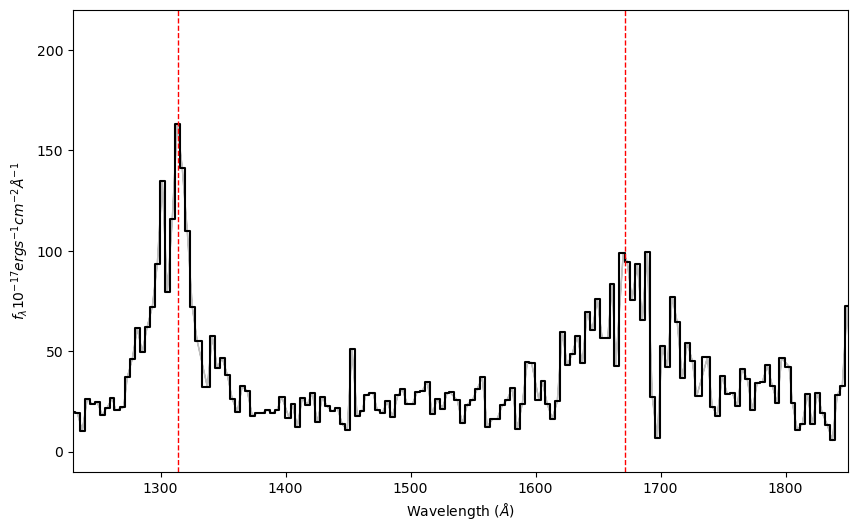

In [3]:
z = 0.081


bin_width = 4

bins = np.arange(min(t["WAVELENGTH"]), max(t["WAVELENGTH"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["WAVELENGTH"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["WAVELENGTH"][in_bin]))
        binned_flux.append(np.mean(t["FLUX"][in_bin]))
        binned_flux_err.append(np.mean(t["ERROR"][in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

rest_wavelength = 1546*(1+z)

c = 299792.458

velocity = c * (binned_wl - rest_wavelength) / rest_wavelength

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=1215.67*(1+z), color='r', linestyle='--', linewidth=1, label="Ly alpha")
plt.axvline(x=1546*(1+z), color='r', linestyle='--', linewidth=1, label="CIV")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(1260, 1360)
#plt.ylim(-10, 220)
plt.xlim(1230, 1850)
plt.ylim(-10, 220)
#plt.legend()
plt.show()

In [4]:
mask = np.where((binned_wl > 1230)&(binned_wl < 1850))[0]

lam = binned_wl[mask]
flux_red = binned_flux[mask]
err  = binned_flux_err[mask]


err[np.where(err==np.inf)] = np.max(err[np.where(err!=np.inf)])

lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)

In [5]:
# download spectrum from SDSS
path_dust = 'C:/Users/serat/Downloads/sfddata-master/'
ra  = 217.5668392
dec =23.06236944
z   = 0.081

In [6]:
# deredden the spectrum

lam = lam/(1+z)
m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

#lam = lam/(1+z)

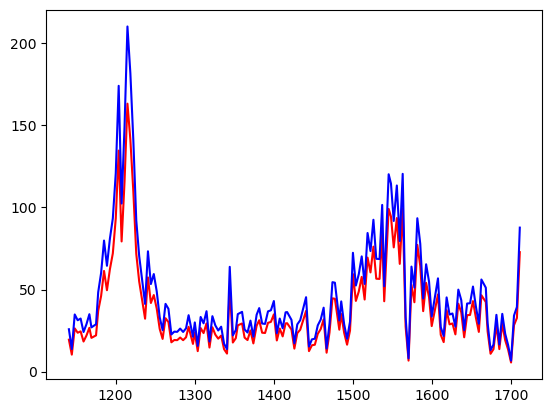

In [7]:
plt.plot(lam, flux_red, 'r')
plt.plot(lam, flux, 'b')
#plt.xlim(1100, 1800)
#plt.ylim(-10, 400)
plt.show()


# Functions

In [8]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [9]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [10]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [11]:
# Need to change for UV

def uv_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                    ly1_f,ly1_cent,ly1_fwhm,\
                    civ_f,civ_cent,civ_fwhm,\
                    return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)
    
    # uv Ly alph template
    ly1 = gaussian(x,ly1_f,ly1_cent,ly1_fwhm,normalized=False)

    # uv oI template
    civ = gaussian(x,civ_f,civ_cent,civ_fwhm,normalized=False)
    
   
    y = ly1 + civ
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'ly1':ly1,\
             'civ':civ}
    
    return y

In [12]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [13]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [14]:
# Need to change

def uv_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(uv_agn_spectrum, 8,
            parnames=['pl_s','pl_e',\
                      'ly1_f', 'ly1_cent', 'ly1_fwhm',\
                      'civ_f', 'civ_cent', 'civ_fwhm'],
                                                    
            parlimited=[(False,False),(False,False),\
                        (False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False)], 
            parlimits=[(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "uvagn"
    
    return myclass

In [15]:
def plot_uv_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    ly1 = model['ly1']
    civ = model['civ']
    #ly2 = model['ly2']
    #ly3 = model['ly3']
    #ly4 = model['ly4']
    
    
    
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl']-400,color=royal_blue)
    ax.plot(wave,ly1-400,color=turquoise)
    ax.plot(wave,civ-400,color=turquoise)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(18, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,flux-model['model'],color=indian_red,lw=2)
    #ax.set_xlim(wavemin,wavemax)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()
    #if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    
    
    ##fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1100,1150)
    #ax.set_ylim(-100, 400)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_CIVfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1100, 1150)
    #ax.set_ylim(0, 62000)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1140, 1300)
    #ax.set_ylim(-100, 400)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1140, 1250)
    #ax.set_ylim(0, 6000)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    
    
    
    

# Setup for plotting

In [16]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

# Setup emission lines

In [17]:
# set up the relevant emission lines
z = 0.081

ly1 = 1215.67
o1 = 1546.15

c = 2.99e5 # km/s

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [24]:
guesses = [5, 0,\
           220, ly1, 5000,\
           150, o1, 1200]
           #240, ly3, 500,\
           #150, ly4, 2000]

step = [0.5, 0.05,\
        0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        0.5, 0.1, 5]
           
tied = ['','',\
        '','','',\
        #'','','',\
        #'','','',\
        '','','']

fixed = [0,0,\
         0,0,0,\
         #0,0,0,\
         #0,0,0,\
         0,0,0]

In [25]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('uvagn',uv_agn_fitter(),8)
spec.specfit.selectregion(xmin=1300,xmax=1650)
spec.specfit(fittype='uvagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 42,137 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  2.651193255e+34  DOF =  87
   PL_S0 = 5  
   PL_E0 = 0  
   LY1_F0 = 220  
   LY1_CENT0 = 1215.67  
   LY1_FWHM0 = 5000  
   CIV_F0 = 150  
   CIV_CENT0 = 1546.15  
   CIV_FWHM0 = 1200  
Iter       2    CHI-SQUARE =  2.563461715e+34  DOF =  87
   PL_S0 = 5  
   PL_E0 = 0  
   LY1_F0 = 220  
   LY1_CENT0 = 1215.67  
   LY1_FWHM0 = 5000  
   CIV_F0 = 79.45119398  
   CIV_CENT0 = 1545.420551  
   CIV_FWHM0 = 2737.178292  
Iter       3    CHI-SQUARE =  2.277520958e+34  DOF =  87
   PL_S0 = 5  
   PL_E0 = 0  
   LY1_F0 = 220  
   LY1_CENT0 = 1215.67  
   LY1_FWHM0 = 5000  
   CIV_F0 = 84.07892486  
   CIV_CENT0 = 1547.926083  
   CIV_FWHM0 = 6401.885494  
Iter       4    CHI-SQUARE =  1.941868204e+34  DOF =  87
   PL_S0 = 5  
   PL_E0 = 0  
   LY1_F0 = 220  
   LY1_CENT0 = 1215.67  
   LY1_FWHM0 = 5000  
   CIV_F0 = 84.17882351  
   CIV_CENT0 = 1546.684875  
   CIV

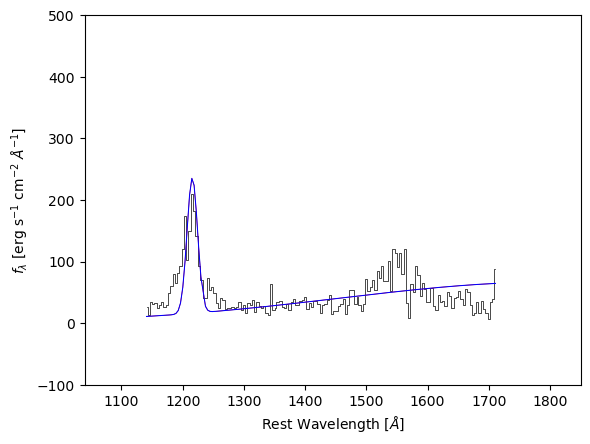

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=1040,xmax=1850,ymin=-100,ymax=500,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

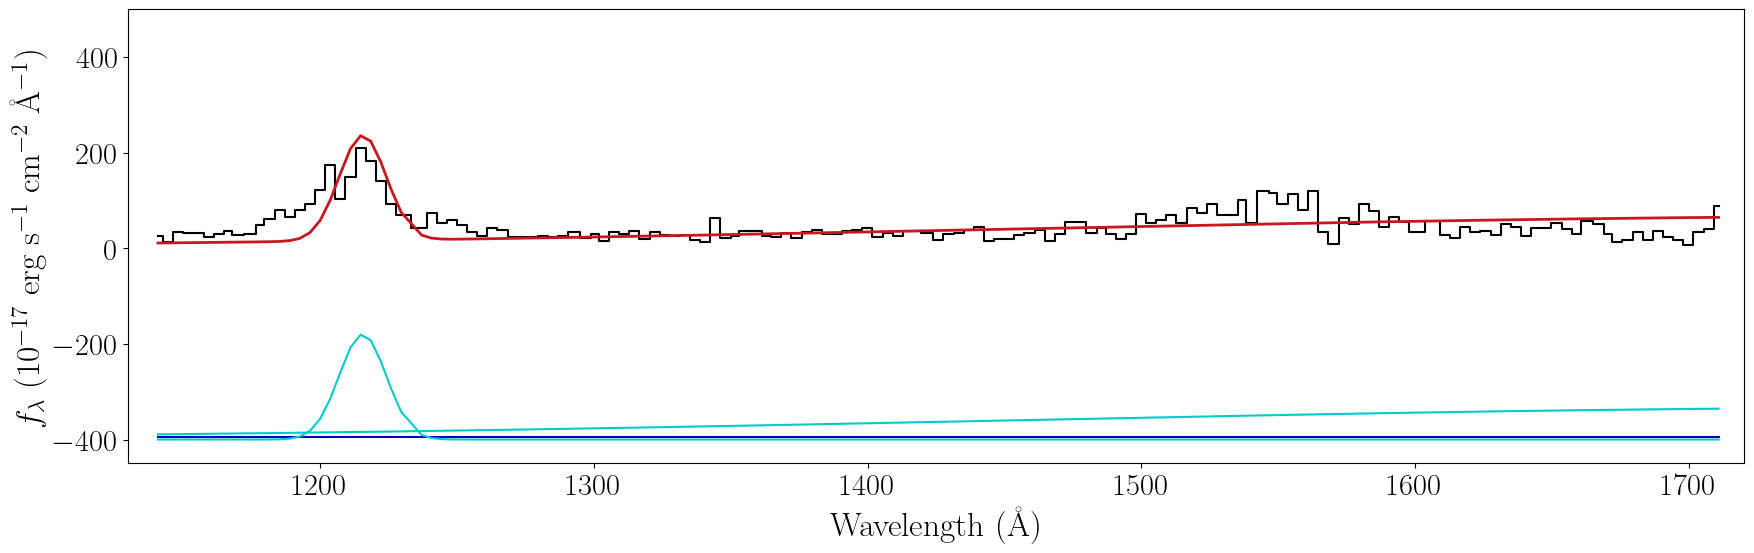

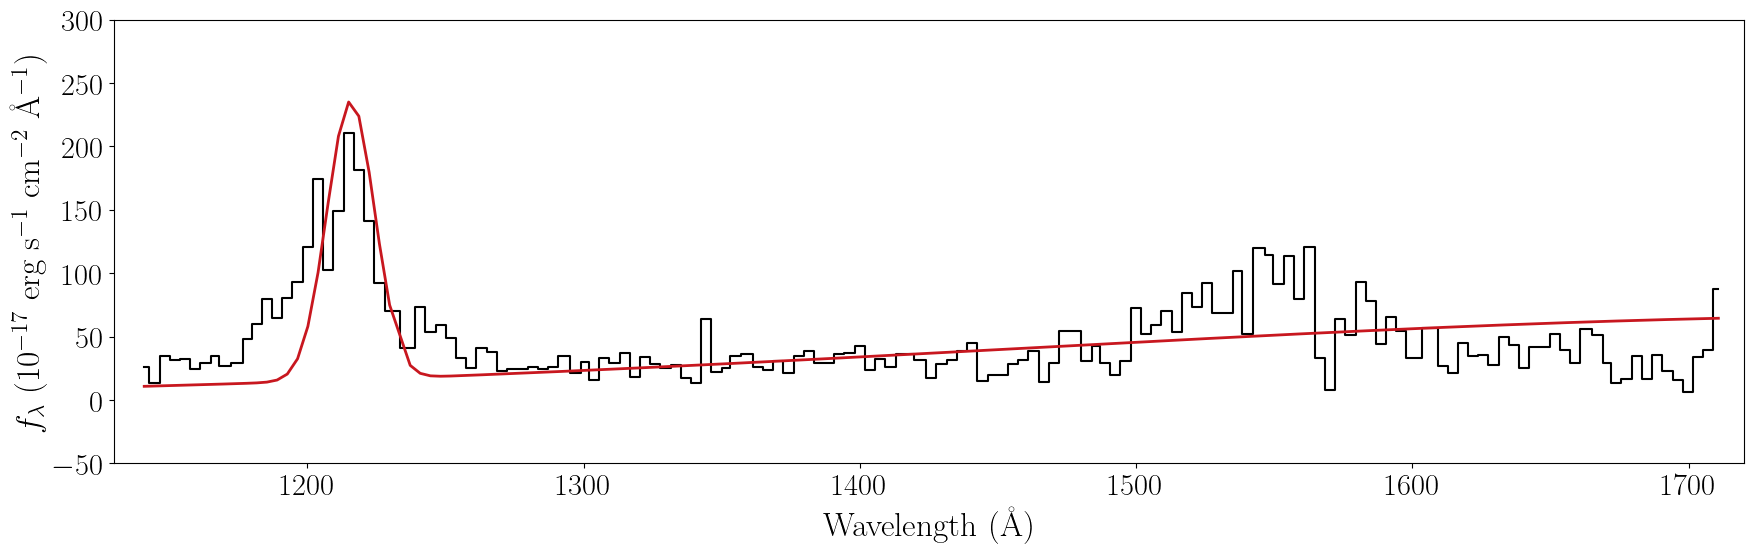

In [27]:
best_model = uv_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = 'uv1'
HARDCOPY = False
SHOW = True
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

plot_uv_agn_fit(lam,flux,best_model,1130,1720,-450,500,'Wavelength (\AA)',\
                     '$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',\
                     plotfile,HARDCOPY=True,SHOW=True)

plot_uv_agn_fit(lam,flux,best_model,1130,1720,-50,300,'Wavelength (\AA)',\
                     '$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',\
                     plotfile,HARDCOPY=True,SHOW=True)